In [1]:
class Node:
    def __init__(self, item, twu, tf=1, parent=None):
        self.item = item
        self.twu = twu
        self.tf = tf
        self.parent = parent
        self.children = {}
        self.node_link = None
    
    
    def increment_vals(self, twu, tf=1):
        self.twu += twu
        self.tf += tf


    # Draws node with twu and tf vals, for debugging
    def draw_node(self, indent=1):
        print('     ') * indent + f"{self.item}: twu={self.twu}, tf={self.tf}"
        for child in self.children.values():
            child.draw_nodes(indent + 1)

In [2]:
class IHUPTree:
    def __init__(self):
        self.root = Node(item=None, twu=0, tf=0)
        self.header_table = {}


    def update_header(self, node):
        # If item/node has been seen
        if node.item in self.header_table:
            # Traverse linked list of nodes referencing that item
            current = self.header_table[node.item]
            while current.node_link is not None:
                current = current.node_link
            # Add item/node to end of list
            current.node_link = node
        # If item/node has not been seen
        else:
            # Add entry to the table
            self.header_table[node.item] = node


    def insert_transaction(self, transaction, transaction_utility):
        current_node = self.root
        for item in transaction:
            # If the item has already been seen
            if item in current_node.children:
                # Extract the node object
                child = current_node.children[item]
                # Increment the twu by the transaction utility and the freq by one
                child.increment_vals(transaction_utility)
            # If time hasn't been seen
            else:
                # Create new child object
                child = Node(item=item, twu=transaction_utility, parent=current_node)
                # Add the item's node to the current's children
                current_node.children[item] = child
                # Add entry to the table
                self.update_header(child)
            # Traverse through transaction
            current_node = child

    # Draw tree for debugging
    def draw_tree(self):
        for child in self.root.children.values():
            child.draw_node(indent=1)

In [3]:
# Methods used in candidate generation

def get_candidates(tree, minutil, prefix, candidates):
    for item in sorted(tree.header_table.keys()):
        # Create a new candidate by appending the item to the partial itemset made so far
        new_candidate = prefix + [item]
        
        # Sum the utilties
        utility = 0
        # Traverse the list of all appearances of the item in tree
        current = tree.header_table[item]
        while current is not None:
            utility += current.twu
            current = current.node_link

        if utility >= minutil:
            candidates[tuple(new_candidate)] = utility

        proj_tree = get_projected_tree(tree, item)
        # If the tree not empty
        if proj_tree.root.children:
            # Recurse
            get_candidates(proj_tree, minutil, new_candidate, candidates)


def get_projected_tree(full_tree, item):
    proj_tree = IHUPTree()
    if item not in full_tree.header_table:
        return proj_tree
    
    current = full_tree.header_table[item]
    while current is not None:
        prefix_path = get_prefix_path(current)
        if prefix_path:
            proj_tree.insert_transaction(prefix_path, current.twu)
        current = current.node_link
    return proj_tree


def get_prefix_path(node):
    path = []
    current = node.parent
    while current is not None and current.item is not None:
        path.insert(0, current.item)
        current = current.parent
    return path

In [4]:
# Methods for mining that dont store the whole dataset, similar to HW01, to save memory

def exact_high_utilities(candidates, file_path, minutil):
    candidate_utilities = {candidate: 0 for candidate in candidates}
    
    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue  # Skip empty lines

            # Parse the transaction line.
            parts = line.strip().split(':')
            trans_items = parts[0].strip().split()
            # The second part (total utility) is not used for exact utility computation.
            item_utils = [float(x) for x in parts[2].strip().split()]
            
            # Build a map of item to its individual utility in this transaction.
            util_map = {item: util for item, util in zip(trans_items, item_utils)}
            trans_item_set = set(trans_items)
            
            # For each candidate, update its utility if it appears in the current transaction.
            for candidate in candidate_utilities:
                candidate_set = set(candidate)
                if candidate_set.issubset(trans_item_set):
                    # Sum the individual utilities for the items in the candidate from this transaction.
                    candidate_util = sum(util_map[item] for item in candidate)
                    candidate_utilities[candidate] += candidate_util

    print("Finished processing transactions for exact utilities.")
       
    # Filter out candidates whose exact utility is below the minutil threshold.
    hui = {candidate: utility for candidate, utility in candidate_utilities.items() if utility >= minutil}
    
    print(f"Number of high utility candidates: {len(hui)}")

    return hui

def get_high_utility_itemsets(file_path, minutil):
    # Build the initial tree by streaming through the file.
    print("Starting to build IHUPTree from transactions...")

    tree = IHUPTree()
    trans_count = 0
    total_utils = []

    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue

            trans_count += 1

            parts = line.strip().split(':')
            items = parts[0].strip().split()
            total_util = float(parts[1].strip())
            total_utils.append(total_util)

            # We use only items and total_util to build the tree.
            tree.insert_transaction(items, total_util)

    print(f"Stage 1 complete: {trans_count} transactions processed.")
    print(f"Dataset total utility (sum over transactions): {sum(total_utils)}")

    
    print("Stage 2: Generating candidate itemsets from the IHUP-tree...")
    candidates = {}
    get_candidates(tree, minutil, prefix=[], candidates=candidates)
    
    print(f"Stage 2 complete: {len(candidates)} candidates generated.")

    
    print("Stage 3: Computing exact utilities using in-memory transactions...")
    high_utility_itemsets = exact_high_utilities(candidates, file_path, minutil)
    
    print("Stage 3 complete: Exact utility computation finished.")
    return high_utility_itemsets

In [5]:
# Methods for mininfg that load the dataset directly into mem, rather than streaming it, faster but more memory intesive

def exact_high_utilities_inmemory(candidates, transactions, minutil):
    candidate_utilities = {candidate: 0 for candidate in candidates}
    # Precompute candidate sets for fast subset checking.
    candidate_sets = {candidate: frozenset(candidate) for candidate in candidates}
    
    for trans in transactions:
        trans_items, _, item_utils = trans
        trans_item_set = set(trans_items)
        util_map = {item: util for item, util in zip(trans_items, item_utils)}
        
        for candidate, cand_set in candidate_sets.items():
            # Check if the candidate is a subset of the transaction items
            if cand_set.issubset(trans_item_set):
                # Sum up the individual utility values for items in the candidate
                candidate_util = sum(util_map[item] for item in candidate)
                candidate_utilities[candidate] += candidate_util

    # Return only those candidates meeting or exceeding minutil.
    high_utilities = {candidate: utility for candidate, utility in candidate_utilities.items() if utility >= minutil}
    return high_utilities

def get_high_utility_itemsets_inmemory(file_path, minutil):
    tree = IHUPTree()
    transactions = []
    total_utils = [] 

    trans_count = 0

    with open(file_path, 'r') as f:
        trans_count += 1
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split(':')
            items = parts[0].strip().split()
            total_util = float(parts[1].strip())
            total_utils.append(total_util)
            item_utils = [float(x) for x in parts[2].strip().split()]
            # Store the transaction details in memory.
            transactions.append((items, total_util, item_utils))
            # Insert into the IHUP-tree using items and total utility.
            tree.insert_transaction(items, total_util)

    
    print(f"Stage 1 complete: {trans_count} transactions processed.")
    print(f"Dataset total utility (sum over transactions): {sum(total_utils)}")

    print("Stage 2: Generating candidate itemsets from the IHUP-tree...")
    candidates = {}
    get_candidates(tree, minutil, prefix=[], candidates=candidates)
    
    print(f"Stage 2 complete: {len(candidates)} candidates generated.")
    
    print("Stage 3: Computing exact utilities using in-memory transactions...")
    high_util_itemsets = exact_high_utilities_inmemory(candidates, transactions, minutil)
    
    print("Stage 3 complete: Exact utility computation finished.")

    return high_util_itemsets

In [6]:
import os

def write_results_to_file(results, input_file, minutil, output_folder="../output"):
    # Create the output folder if it doesn't exist.
    os.makedirs(output_folder, exist_ok=True)
    
    # Extract the base name without extension.
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    # Build the output file name.
    output_filename = f"{base_name}_high_utility_itemsets_min{minutil}.txt"
    output_path = os.path.join(output_folder, output_filename)
    
    with open(output_path, "w") as file:
        for itemset, utility in results.items():
            # Convert the tuple candidate to a string using a space separator.
            itemset_str = ' '.join(itemset)
            file.write(f"{itemset_str} {utility}\n")
    
    print(f"Results have been written to: {output_path}")


In [ ]:
# Singular Test for Debugging

input_dir = "../data/"
input_file = "Chicago_Crimes_2001_to_2017_utility.txt"
file_path = input_dir + input_file
minutil = 794100

high_utility_itemsets = get_high_utility_itemsets_inmemory(file_path, minutil)
HUI = get_high_utility_itemsets(file_path, minutil)

write_results_to_file(high_utility_itemsets, input_file, minutil)


Total dataset utility: 7941285.0

Running with min utility = 79412.85 (i.e., 1.0%)...
Starting to build IHUPTree from transactions...
Stage 1 complete: 2662309 transactions processed.
Dataset total utility (sum over transactions): 7941285.0
Stage 2: Generating candidate itemsets from the IHUP-tree...
Stage 2 complete: 354 candidates generated.
Stage 3: Computing exact utilities using in-memory transactions...
Finished processing transactions for exact utilities.
Number of high utility candidates: 183
Stage 3 complete: Exact utility computation finished.
Streaming: 123.18 sec, 183 candidates, peak memory: 251.52 MB
Stage 1 complete: 1 transactions processed.
Dataset total utility (sum over transactions): 7941285.0
Stage 2: Generating candidate itemsets from the IHUP-tree...
Stage 2 complete: 354 candidates generated.
Stage 3: Computing exact utilities using in-memory transactions...
Stage 3 complete: Exact utility computation finished.
In-Memory: 39.85 sec, 183 candidates, peak memory: 

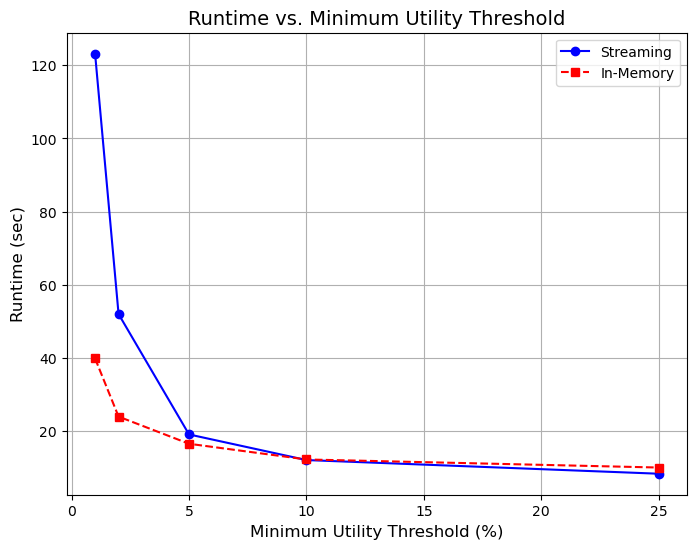

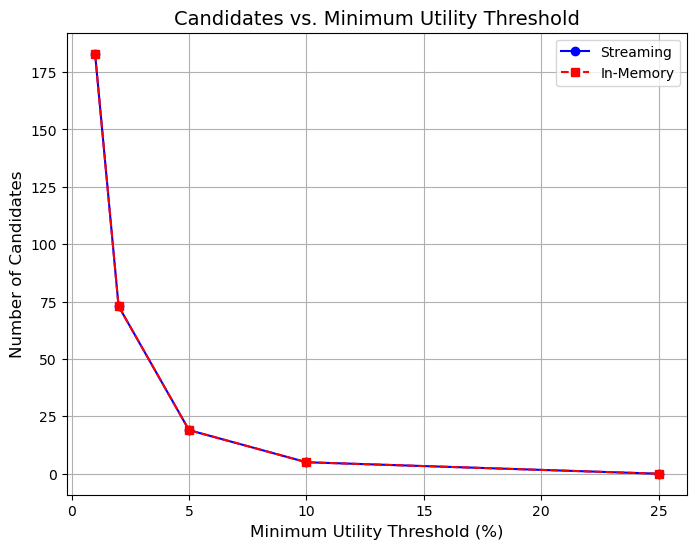

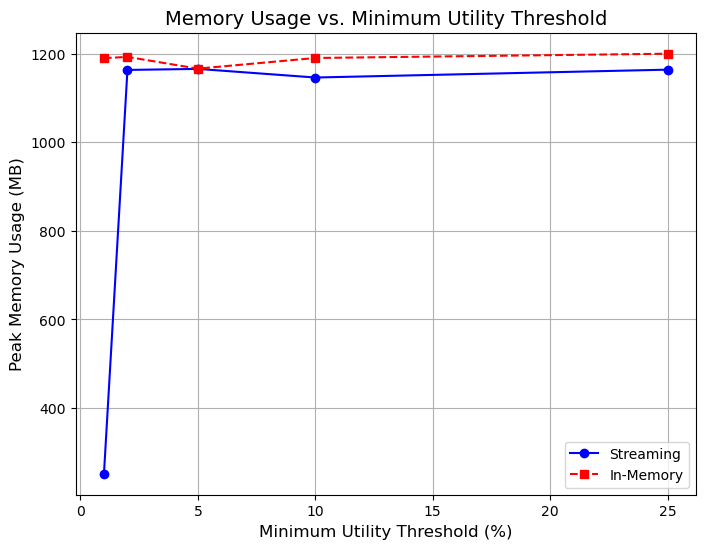

In [9]:
import time
import os
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

def compute_total_dataset_utility(file_path):
    total_util = 0.0
    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split(':')
            total_util += float(parts[1].strip())
    return total_util

input_dir = "../data/"
input_file = "Chicago_Crimes_2001_to_2017_utility.txt"
file_path = os.path.join(input_dir, input_file)

total_dataset_utility = compute_total_dataset_utility(file_path)
print(f"Total dataset utility: {total_dataset_utility}")

threshold_percentages = [0.01, 0.02, 0.05, 0.1, 0.25]

runtimes_stream = {}
runtimes_memory = {}
candidates_stream = {}
candidates_memory = {}
memory_usage_stream = {}
memory_usage_memory = {}

for pct in threshold_percentages:
    min_util = total_dataset_utility * pct
    print(f"\nRunning with min utility = {min_util} (i.e., {pct*100}%)...")

    start = time.time()
    mem_trace, hui_stream = memory_usage(
        (get_high_utility_itemsets, (file_path, min_util), {}),
        interval=0.1,
        retval=True
    )
    runtime_stream = time.time() - start
    peak_mem_stream = max(mem_trace)
    runtimes_stream[pct] = runtime_stream
    candidates_stream[pct] = len(hui_stream)
    memory_usage_stream[pct] = peak_mem_stream
    print(f"Streaming: {runtime_stream:.2f} sec, {len(hui_stream)} candidates, peak memory: {peak_mem_stream:.2f} MB")
    
    start = time.time()
    mem_trace, hui_memory = memory_usage(
        (get_high_utility_itemsets_inmemory, (file_path, min_util), {}),
        interval=0.1,
        retval=True
    )
    runtime_memory = time.time() - start
    peak_mem_memory = max(mem_trace)
    runtimes_memory[pct] = runtime_memory
    candidates_memory[pct] = len(hui_memory)
    memory_usage_memory[pct] = peak_mem_memory
    print(f"In-Memory: {runtime_memory:.2f} sec, {len(hui_memory)} candidates, peak memory: {peak_mem_memory:.2f} MB")

x_values = [pct * 100 for pct in threshold_percentages]

y_runtime_stream = [runtimes_stream[pct] for pct in threshold_percentages]
y_runtime_memory = [runtimes_memory[pct] for pct in threshold_percentages]

y_candidates_stream = [candidates_stream[pct] for pct in threshold_percentages]
y_candidates_memory = [candidates_memory[pct] for pct in threshold_percentages]

y_memory_stream = [memory_usage_stream[pct] for pct in threshold_percentages]
y_memory_memory = [memory_usage_memory[pct] for pct in threshold_percentages]

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_runtime_stream, marker='o', linestyle='-', color='blue', label='Streaming')
plt.plot(x_values, y_runtime_memory, marker='s', linestyle='--', color='red', label='In-Memory')
plt.xlabel("Minimum Utility Threshold (%)", fontsize=12)
plt.ylabel("Runtime (sec)", fontsize=12)
plt.title("Runtime vs. Minimum Utility Threshold", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_candidates_stream, marker='o', linestyle='-', color='blue', label='Streaming')
plt.plot(x_values, y_candidates_memory, marker='s', linestyle='--', color='red', label='In-Memory')
plt.xlabel("Minimum Utility Threshold (%)", fontsize=12)
plt.ylabel("Number of Candidates", fontsize=12)
plt.title("Candidates vs. Minimum Utility Threshold", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_memory_stream, marker='o', linestyle='-', color='blue', label='Streaming')
plt.plot(x_values, y_memory_memory, marker='s', linestyle='--', color='red', label='In-Memory')
plt.xlabel("Minimum Utility Threshold (%)", fontsize=12)
plt.ylabel("Peak Memory Usage (MB)", fontsize=12)
plt.title("Memory Usage vs. Minimum Utility Threshold", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()